<h1 style="text-align: center;">Projet IMA201 :  Waterpixels</h1>

#### Elèves: Aït El Cadi Yanis, Chahboune Zakaria

#### Encadrant: Michel Roux

### Présentation du projet
Pour segmenter des images, il est parfois intéressant de partionner l’image en plusieurs zones homogènes, appelées des super-pixels. Il existe plusieurs techniques pour obtenir cette partition, celle sur laquelle nous travaillons utilise l’algorithme du watershed. Les super-pixels
ainsi obtenus s’appellent des waterpixels. 

Pour ce faire, nous nous sommes  appuyés sur un travail de recherche existant : 
Vaïa Machairas, Matthieu Faessel, David Cárdenas-Peña, Théodore Chabardes, Thomas Walter, et al.. Waterpixels. IEEE Transactions on Image Processing, Institute of Electrical and Electronics Engineers, 2015, 24 (11), pp.3707 - 3716. ff10.1109/TIP.2015.2451011ff. ffhal-01212760f

Voici les étapes à suivre pour obtenir une image segmentée en waterpixels :
1. Opening/Closing de l'image
2. Calcul du gradient de l’image
3. Définition de cellules régulières sur l’image centrées sur une grille régulière
4. Séléction de marqueurs pour chaque cellule
5. Régularisation du gradient grâce à une mesure de distance
6. Application de l’algorithme du watershed sur le gradient de l’étape 4 depuis les marqueurs
de l’étape 3 

Une fois l'image segmentée obtenue, nous évaluerons l'efficacité de certains paramètres lors de la segmentation ainsi que la qualité des waterpixels eux-mêmes.

In [15]:
### IMPORTS
import numpy as np
from matplotlib import pyplot as plt
import cv2
import math
from PIL import Image
from scipy.ndimage import label
from scipy.spatial import Voronoi, voronoi_plot_2d
from scipy.interpolate import griddata
import skimage.morphology as morpho
from skimage import io, color
from skimage.segmentation import watershed
from operator import itemgetter
import time
import collections.abc

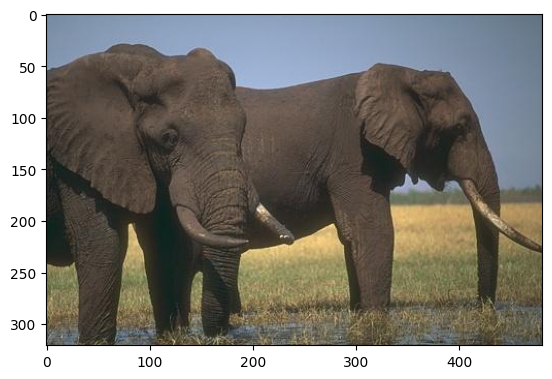

In [16]:
# Importations de l'image
img = plt.imread('elephant.jpg')
plt.imshow(img, cmap='gray')
plt.show()

### 1. Opening / Closing

L'objectif est de limiter l'impact des zones avec des hautes variations de gradient sur la segmentation.

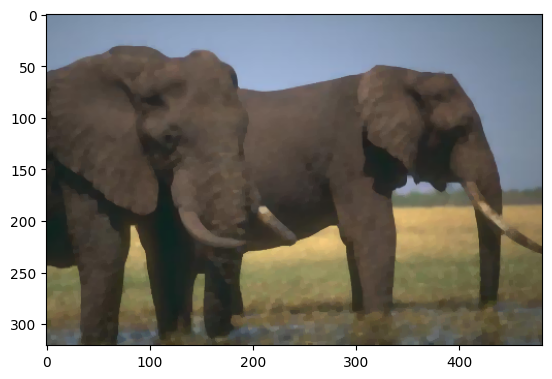

In [17]:
def open_close(gray,sigma):
    gray = np.asarray(gray, dtype=np.uint8) # Specifying dtype is critical here
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(math.ceil(sigma*sigma/16),math.ceil(sigma*sigma/16)))
    opening = cv2.morphologyEx(gray, cv2.MORPH_OPEN, kernel)
    closing = cv2.morphologyEx(opening, cv2.MORPH_CLOSE, kernel)
    #plt.imshow(closing,cmap='gray')
    #plt.show()
    return closing

plt.imshow(open_close(img,8))
plt.show()

### 2. Gradient
Le calcul du gradient peut se faire de plusieurs manières, qui seront testées dans l'étape d'évaluation: Sobel, Prewitt, gradient morphologique.

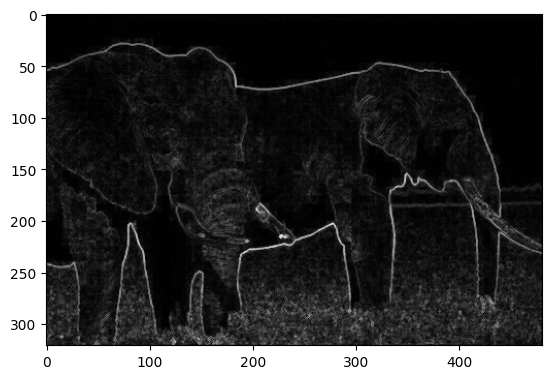

In [18]:
# Sobel
def sobel(im):
    gray = np.asarray(im, dtype=np.uint8) # Specifying dtype is critical here
    kernelx = np.array([[-1,0,1],[-2,0,2],[-1,0,1]])
    kernely = np.array([[1, 2, 1],[0, 0, 0],[-1,-2,-1]])
    img_x = cv2.filter2D(gray, -1, kernelx)
    img_y = cv2.filter2D(gray, -1, kernely)
    
    #taking root of squared sum and displaying result
    sobel=np.hypot(img_x,img_y)
    sobel = sobel[:,:,0]
    sobel = sobel.astype('int')
    mx = max_im(sobel)
    for i in range(len(sobel)):
        for j in range(len(sobel[0])):
            sobel[i][j] = int(sobel[i][j]*255/mx)
    return sobel

#Prewitt
def prewitt(im):
    gray = np.asarray(im, dtype=np.uint8) # Specifying dtype is critical here

    kernelx = np.array([[1,1,1],[0,0,0],[-1,-1,-1]])

    kernely = np.array([[-1,0,1],[-1,0,1],[-1,0,1]])

    img_prewittx = cv2.filter2D(gray, -1, kernelx)
    img_prewitty = cv2.filter2D(gray, -1, kernely)

    prewitt = np.hypot(img_prewitty,img_prewittx)
    prewitt = prewitt[:,:,0]
    prewitt = prewitt.astype('int')
    mx = max_im(prewitt)
    for i in range(len(prewitt)):
        for j in range(len(prewitt[0])):
            prewitt[i][j] = int(prewitt[i][j]*255/mx)
    #plt.imshow(prewitt,cmap='gray')
    #plt.show()
    return prewitt

# Gradient Morphologique
def morpho_gradient(img):
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    morpho_grad = morpho.dilation(img)- morpho.erosion(img)
    morpho_grad = morpho_grad.astype('int')
    return morpho_grad

# Get the maximumu value of an image (for normalization)
def max_im(im):
    max = 0
    for elt in im:
        for el in elt:
            if el > max:
                max = el
    return max

# morpho_grad = morpho_gradient(img)
# grad_prewitt = prewitt(img)
#grad = sobel(img)
# plt.imshow(grad, cmap='gray')
grad = morpho_gradient(img)
plt.imshow(grad, cmap='gray')
plt.show()

### 3. Cellules rectangulaires

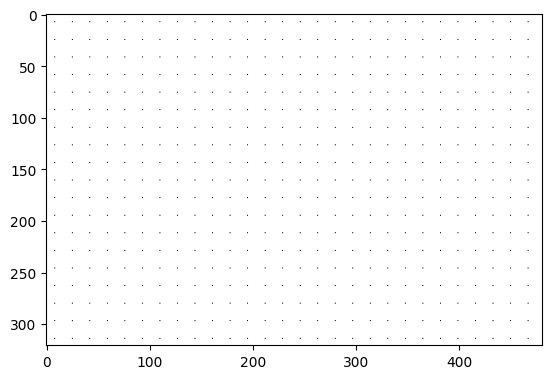

In [19]:
# Returns a list of coordinates of centered rectangles 
def get_coord(grad,height_nb,width_nb):
    height = len(grad)
    width = len(grad[0])
    list_of_rectangles = []
    sigma_height = math.ceil(height/height_nb)
    sigma_width = math.ceil(width/width_nb)
    count = 0
    for i in range(height_nb):
        count+=1
        for j in range(width_nb):
            if sigma_height*(i+1) <= height and sigma_width*(j+1) <= width:
                list_of_rectangles.append([count%255,[sigma_height//2 + sigma_height*i,sigma_width//2 +sigma_width*j],[sigma_height//2 + sigma_height*(i+1),sigma_width//2 +sigma_width*j],[sigma_height//2 +sigma_height*i,sigma_width//2 +sigma_width*(j+1)],[sigma_height//2 +sigma_height*(i+1),sigma_width//2 +sigma_width*(j+1)]])
            count +=1
    for elt in list_of_rectangles:
        to_delete = 0
        for coo in elt[1:]:
            if coo[0] > height or coo[1] > width:
                to_delete = 1
        if to_delete == 1:
            list_of_rectangles.remove(elt)
    return list_of_rectangles

def show_rectangles(grad,list_of_rectangles):
    height = len(grad)
    width = len(grad[0])
    grid_ima = [[1 for i in range(width)] for i in range(height)]
    for elt in list_of_rectangles:
        grid_ima[elt[1][0]][elt[1][1]] = 0
        grid_ima[elt[2][0]][elt[2][1]] = 0
        grid_ima[elt[3][0]][elt[3][1]] = 0
        grid_ima[elt[4][0]][elt[4][1]] = 0
    plt.imshow(grid_ima,cmap='gray')
    plt.show()
    return

show_rectangles(grad,get_coord(grad,20,30))

### 4. Selection des marqueurs

Pour chaque cellule, on cherche la valeur minimale du gradient dans celle-ci. Puis, on regarde le groupe de pixels connexes de plus grande taille ayant cette valeur.

![alternative text](select_markers.png)

In [20]:
def get_cc_v2(grad,list_of_rectangles,to_print):
    s = time.time()
    clusters = [[0 for i in range(len(grad[0]))] for i in range(len(grad))]
    coord_clusters=[]
    list_nearest = [[0 for i in range(len(grad[0]))] for i in range(len(grad))]
    for_show = [[0 for i in range(len(grad[0]))] for i in range(len(grad))]
    list_clusters_with_rep = []
    for elt in list_of_rectangles:
        rect = np.array([sublist[elt[1][1]+1:elt[3][1]-1] for sublist in grad[elt[1][0]+1:elt[2][0]-1]])
        if len(rect) != 0:
            grad_min = 255
            for i in range(len(rect)):
                for j in range(len(rect[0])):
                    if rect[i][j] <grad_min:
                        grad_min = rect[i][j]
            rect[rect!=grad_min]=-1
            rect[rect==grad_min]+=1
            rect[rect==-1]=0
            #structure = np.ones((3, 3), dtype=int)
            labeled, ncomponents = label(rect)
            max_size = 0
            indice = 1
            shape = rect.shape
            indices = np.indices((shape[1],shape[0])).T[:,:,[1, 0]]
            for i in range(1,ncomponents+1):
                size = len(indices[labeled == i])
                if size > max_size:
                    max_size = size
                    indice = i
            coordinates = indices[labeled == indice].copy()
        for i in range(len(coordinates)):
            coordinates[i] = [coordinates[i][0] + elt[1][0], coordinates[i][1] + elt[1][1]]
        for i in range(len(rect)):
            if len(rect) + elt[1][0] == len(grad) - 10:
                for j in range(len(rect[0])+10):
                    x = i + elt[1][0]
                    y = j + elt[1][1]
                    l = [x,y]
                    if x < len(list_nearest) and y < len(list_nearest[0]):
                        list_nearest[x][y] = nearest_center(l,coordinates)
                        for_show[x][y] = 255
            else :
                for j in range(len(rect[0])):
                    x = i + elt[1][0]
                    y = j + elt[1][1]
                    l = [x,y]
                    if x < len(list_nearest) and y < len(list_nearest[0]):
                        list_nearest[x][y] = nearest_center(l,coordinates)
        for coo in coordinates:
            #if coo[0] < len(clusters) and coo[1] < len(clusters[1]) :
            clusters[coo[0]][coo[1]] = elt[0]
            for_show[coo[0]][coo[1]] = 255
            coord_clusters.append(coo)
        list_clusters_with_rep.append([elt,coordinates])
            #list_nearest[coo[0]][coo[1]] = nearest_center(coo,coordinates)
    #plt.imshow(clusters,cmap='gray')
    #plt.show()
    if to_print:
        plt.imshow(np.array(for_show))
        plt.show()
    print("Time to get markers : ",time.time() - s)
    return clusters,sorted(coord_clusters,key=itemgetter(0,1)),list_nearest,list_clusters_with_rep

# Given a coordinate and a list of coordinates, returns the closest coordinate in the list to the first one
def nearest_center(coord,list_of_centers):
    nearest = [-1,-1]
    dmin = 1000000
    for elt in list_of_centers:
        distance = (coord[0]-elt[0])**2 + (coord[1]-elt[1])**2
        if distance < dmin:
            dmin = distance
            nearest = elt
    assert len(nearest) > 0
    return nearest

### 5. Régularisation du gradient

Chaque pixel du gradient se voit attribuer une nouvelle valeur, plus celui-ci est loin d'un cluster, plus sa valeur est augmentée.

In [21]:
def grad_reg_v2(grad,list_nearest,list_centers,clust_rep,sigma,rho):
    list_centers = np.array(list_centers)
    s = time.time()
    count=0
    for i in range(len(grad)):
        for j in range(len(grad[0])):
            #if [i,j] not in list_centers:
            if not hasattr(list_nearest[i][j],"__len__"):
                n_c = nearest_cluster([i,j],clust_rep)
                list_nearest[i][j] = nearest_center([i,j],clust_rep[n_c][1])
    print("Time to fill nearest centers : ",time.time() - s)
    image = [[0 for i in range(len(grad[0]))] for i in range(len(grad))]
    s2 = time.time()
    for i in range(len(grad)):
        for j in range(len(grad[0])):
            #if [i,j] not in list_centers:
            center = list_nearest[i][j]
            distance_from_center = math.sqrt((center[0]-i)**2 + (center[1]-j)**2)
            image[i][j] = int(grad[i][j]*(2+rho*distance_from_center*2/sigma))
    mx = max_im(image)
    for i in range(len(image)):
        for j in range(len(image[0])):
            image[i][j] = int(image[i][j]*255/mx)
    #print(mx)
    print("Time to do the homothety : ", time.time() - s2)
    return image

def nearest_cluster(coord,clusters):
    nearest = -1
    dmin = 1000000
    count=0
    #print(clusters)
    for elt in clusters:
        center = [(elt[0][2][0]-elt[0][1][0])//2,(elt[0][3][1]-elt[0][2][1])//2]
        distance = (coord[0]-center[0])**2 + (coord[1]-center[1])**2
        #print(distance)
        if distance < dmin:
            dmin = distance
            nearest = count
        count += 1
    return nearest

![alternative text](img.jpg)

### 6. Application du watershed

L'idée de base derrière toutes les méthodes de segmentation basées sur la ligne de partage des eaux est de considérer une image à niveaux de gris comme un relief topographique. Il s'agit alors de calculer la ligne de partage des eaux dudit relief. Les bassins versants ainsi obtenus correspondent aux régions de la partition.

Résultat de l'algorithme du watershed sur une fonction à une dimension : 

![alternative text](The-segmentation-process-of-the-watershed-algorithm.png)

START


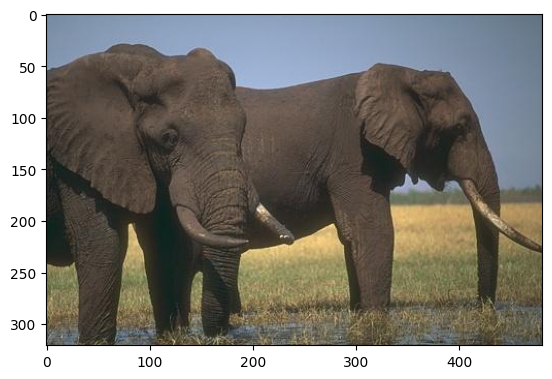

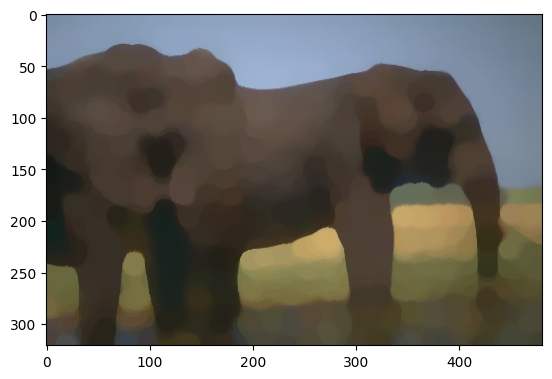

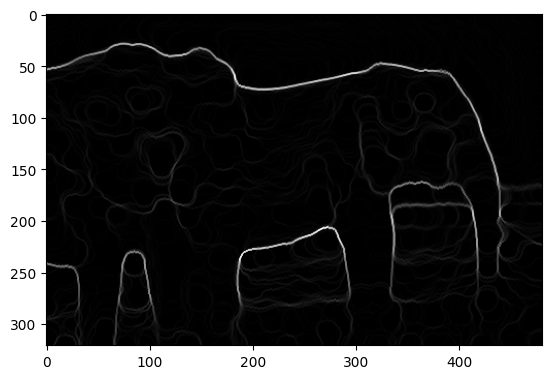

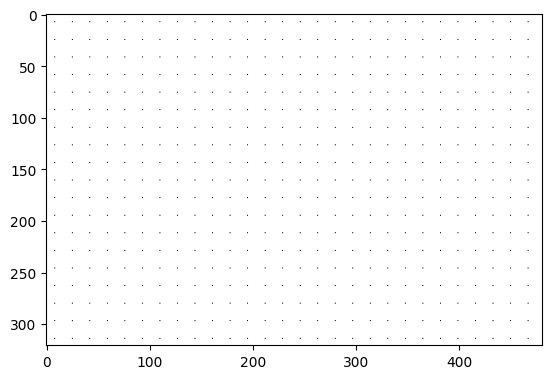

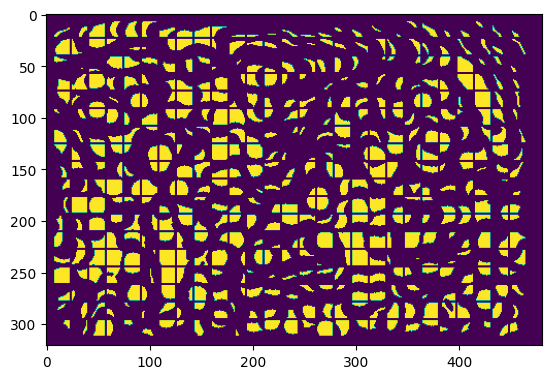

Time to get markers :  7.258434772491455
Time to fill nearest centers :  29.971877574920654
Time to do the homothety :  0.5937631130218506


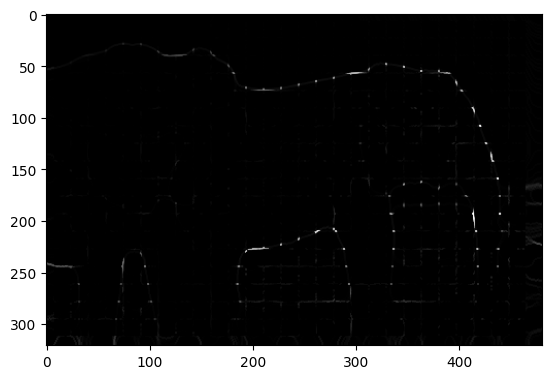

Total time for determining waterpixels :  39.5511519908905
END


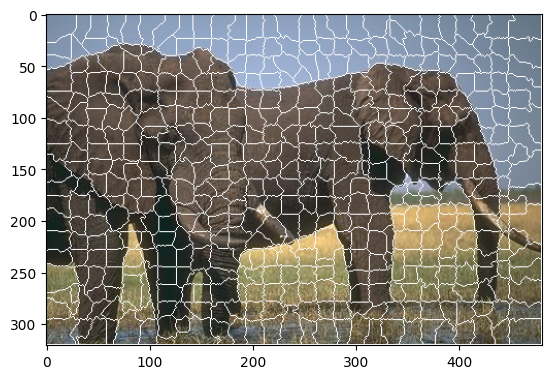

In [24]:
def waterpixels(img,nb_height,sigma_adjust=1,rho=1,to_print = False,type_of_gradient="morpho",to_open_close=True):
    print("START")
    start = time.time()
    ima = cv2.imread(img)
    ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
    if to_print:
        plt.imshow(ima)
        plt.show()
        plt.close()
    height = len(ima)
    width = len(ima[0])
    nb_width = int(width/height*nb_height) +1
    sigma_height = math.ceil(height/nb_height)
    sigma_width = math.ceil(width/nb_width)
    sigma = (sigma_width + sigma_height)/2 * sigma_adjust
    if to_open_close:
        im = open_close(ima,sigma)
    else :
        im = ima
    if to_print:
        plt.imshow(im)
        plt.show()
        plt.close()
    #grad_ = prewitt(ima)
    if type_of_gradient == "morpho":
        grad_ = morpho_gradient(im)
    elif type_of_gradient == "prewitt":
        grad_ = prewitt(ima)
    elif type_of_gradient == "sobel":
        grad_ = sobel(ima)
    if to_print:
        plt.imshow(grad_,cmap='gray')
        plt.show()
        plt.close()
    grid_ = get_coord(grad_,nb_height,nb_width)
    if to_print:
        show_rectangles(grad_,grid_)
        plt.close()
    grid_,clust_,l_near,clu_rep = get_cc_v2(grad_,grid_,to_print)
    #grad_ = np.array(homothety(grad_,clust_,sigma,rho))
    grad_ = np.array(grad_reg_v2(grad_,l_near,clust_,clu_rep,sigma,rho))
    if to_print:
        plt.imshow(grad_,cmap='gray')
        plt.show()
        plt.close()
    cv2.imwrite("img.jpg",grad_)
    img = cv2.imread("img.jpg", cv2.IMREAD_COLOR)
    markers = np.array(grid_.copy())
    markers = markers.astype(np.int32)
    cv2.watershed(img, markers)
    output_image = np.zeros_like(img)
    for marker in np.unique(markers):
        if marker == -1:
            continue  # Skip markers
        mask = np.zeros_like(img)
        mask[markers == marker] = 255
        output_image += mask
    ima[output_image==[0,0,0]] = 255
    print("Total time for determining waterpixels : ",time.time()-start)
    print("END")
    if to_print:
        plt.close()
        plt.imshow(ima)
        plt.show()
        plt.close()
    ima = cv2.cvtColor(ima, cv2.COLOR_BGR2RGB)
    cv2.imwrite("waterpixels2.jpg",ima)
    return output_image

a = waterpixels("elephant.jpg",20,to_print=True)
#boundary_recall(a,"GT_elephants.jpg")

![alternative text](vase_wp.jpg)
![alternative text](vaches_wp.jpg)
![alternative text](chevaux_wp.jpg)

De manière qualitative, on voit que les waterpixels suivent les contours des éléments de l'image.

### 7. Evaluations des waterpixels

We use two measures to evaluate the pertinence of the resulting waterpixels :
- Contour density : it is equal to the number of pixels that are within the border of a waterpixel plus the pixels on the border of the image divided by the total number of pixels in the image.
- Boundary recall : it is equal to the number of pixels that we know are on the contour of an object that are within " pixels of the border of a waterpixel (we get this ground truth image from the Berkeley Image Dataset) divided by the total number of ground truth pixels. It is within 0 and 1 and it can be seen as the percentage of pixels within contours that are on the edge of a waterpixel.

![alternative text](cd_br_formula.png)

In [ ]:
def contour_density(sp_im):
    cd = 0
    cd += len(sp_im)*2
    cd += len(sp_im[0])*2 
    for i in range(len(sp_im)):
        for j in range(len(sp_im[0])):
            if sp_im[i][j][0] == 0:
                cd += 1/2
    cd = cd / (len(sp_im)*len(sp_im[0]))
    return cd

def boundary_recall(sp_im,gt_im):
    ima = cv2.imread(gt_im)
    ima = cv2.cvtColor(ima, cv2.COLOR_BGR2GRAY)
    sp_im = cv2.cvtColor(sp_im, cv2.COLOR_BGR2GRAY)
    gt_card = 0
    for elt in ima:
        for elt_ in elt:
            if elt_ == 0:
                gt_card += 1
    br = 0
    for i in range(len(ima)):
        for j in range(len(ima[0])):
            if ima[i,j] ==0:
                if is_sp_close(3,[i,j],sp_im):
                    br +=1
    br = br / gt_card
    return br

def is_sp_close(distance,coo,sp_im):
    for i in range(max(0,coo[0]-distance),min(len(sp_im),coo[0]+distance)):
        for j in range(max(0,coo[1]-distance),min(len(sp_im[0]),coo[1]+distance)):
            if sp_im[i][j] == 0 and manhattan_d([i,j],coo) < distance:
                return True
    return False

def manhattan_d(x,y):
    x1 = abs(x[0]-y[0])
    x2 =abs(x[1]-y[1])
    y = x1 + x2
    return y

def max(a,b):
    if a>b:
        return a
    else :
        return b

def min(a,b):
    if a>b:
        return b
    else :
        return a

def abs(a):
    if a < 0:
        return -a
    else :
        return a

def get_best_sigma_adjust(img,gt_img):
    br_list = []
    cd_list = []
    for sigma_ad in range(1,20):
        wp = waterpixels(img,20,sigma_ad)
        br = boundary_recall(wp,gt_img)
        cd = contour_density(wp)
        br_list.append([sigma_ad,br])
        cd_list.append([sigma_ad,cd])
    br_max = 0
    best_sigma_br = -1
    for elt in br_list:
        if elt[1] > br_max:
            br_max = elt[1]
            best_sigma_br = elt[0]
    cd_max = 0
    best_sigma_cd = -1
    for elt in cd_list:
        if elt[1] > cd_max :
            cd_max = elt[1]
            best_sigma_cd = elt[0]
    return best_sigma_br,best_sigma_cd,br_list,cd_list

def get_best_rho(img,gt_img):
    starting = time.time()
    br_list = []
    cd_list = []
    for i in range(20):
        rho_ad = i
        print(rho_ad)
        wp = waterpixels(img,20,rho = rho_ad)
        br = boundary_recall(wp,gt_img)
        print(br)
        cd = contour_density(wp)
        br_list.append([rho_ad,br])
        cd_list.append([rho_ad,cd])
    br_max = 0
    best_rho_br = -1
    for elt in br_list:
        if elt[1] > br_max:
            br_max = elt[1]
            best_rho_br = elt[0]
    cd_max = 0
    best_rho_cd = -1
    for elt in cd_list:
        if elt[1] > cd_max :
            cd_max = elt[1]
            best_rho_cd = elt[0]
    print(time.time() - starting)
    return best_rho_br,best_rho_cd,br_list,cd_list

def get_best_rho_sigma_couple(img,gt_img):
    results = []
    count=0
    for i in range(1,20):
        for j in range(1,20):
            print("Itération : ", count)
            rho_ad = i/20
            sigma_ad = j/20
            wp = waterpixels(img,25,sigma_adjust = sigma_ad,rho = rho_ad)
            br = boundary_recall(wp,gt_img)
            cd = contour_density(wp)
            results.append([[rho_ad,sigma_ad],br,cd])
            count += 1
    br_max = 0
    best_rho_sigma_br = -1
    for elt in results:
        if elt[1] > br_max:
            br_max = elt[1]
            best_rho_sigma_br = elt[0]
    cd_max = 0
    best_rho_sigma_cd = -1
    for elt in results:
        if elt[2] > cd_max :
            cd_max = elt[2]
            best_rho_sigma_cd = elt[0]
    return best_rho_sigma_br,best_rho_sigma_cd,results

### What type of gradient should we use ?

In [ ]:
a = waterpixels("elephants.jpg",25)
cd_morpho = contour_density(a)
br_morpho = boundary_recall(a,"GT_elephants.jpg")
a = waterpixels("elephants.jpg",25,type_of_gradient="prewitt")
cd_prewitt = contour_density(a)
br_prewitt= boundary_recall(a,"GT_elephants.jpg")
a = waterpixels("elephants.jpg",25,type_of_gradient="sobel")
cd_sobel = contour_density(a)
br_sobel = boundary_recall(a,"GT_elephants.jpg")

results_gradients = [br_morpho,br_prewitt,br_sobel,cd_morpho,cd_prewitt,cd_sobel]

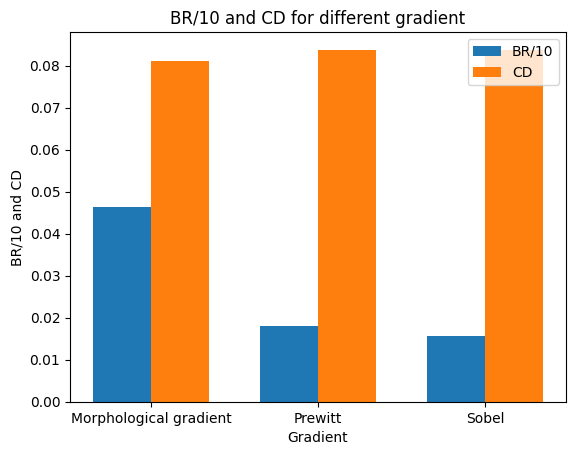

In [ ]:
categories = ['Morphological gradient', 'Prewitt', 'Sobel']
values1 = [0.0464, 0.0181, 0.0156]
values2 = [0.08124,0.08381,0.08364]
bar_width = 0.35
indices = np.arange(len(categories))
fig, ax = plt.subplots()
bar1 = ax.bar(indices - bar_width/2, values1, bar_width, label='BR/10')
bar2 = ax.bar(indices + bar_width/2, values2, bar_width, label='CD')
ax.set_xlabel('Gradient')
ax.set_ylabel('BR/10 and CD')
ax.set_title('BR/10 and CD for different gradient')
ax.set_xticks(indices)
ax.set_xticklabels(categories)
ax.legend()
plt.show()

Le contour density change peu en fonction du gradient, cependant le gradient morphologique augmente de quelques pourcents le boundary recall.

### Link between the number of rectangles used for the mask and the boundary recall

In [ ]:
ima = cv2.imread("elephants.jpg")
height = len(ima)
width = len(ima[0])
link_br_nb = []
for nb in range(10,50):
    print(nb)
    a = waterpixels("C://Users//boite//Desktop//2A//IMA//IMA201(a)//Waterpixels//elephants.jpg",nb,to_print=False)
    nb_width = int(width/height*nb) +1
    br = boundary_recall(a,"GT_elephants.jpg")
    link_br_nb.append([nb*nb_width,br])

![alternative text](br_nb_rectangles_good.png)

Le lien est logique car plus on augmente le nombre de superpixels, plus il y a de contours de superpixels et plus ceux-ci ont de chance de se trouver sur les contours de l'image d'origine.

### Link between the value of rho in the regulation of the gradient and BR/CD

In [ ]:
best_rho_br,best_rho_cd,br_list,cd_list = get_best_rho("elephants.jpg","GT_elephants.jpg")

![alternative text](br_k.png)
![alternative text](cd_k.png)

Le graphique sur le boundary recall est cohérent avec le fait que lorsque rho tend vers l'infini, la régularisation du gradient tend vers la tessellation de Voronoï. 